Reference: https://machinelearningmastery.com/super-learner-ensemble-in-python/
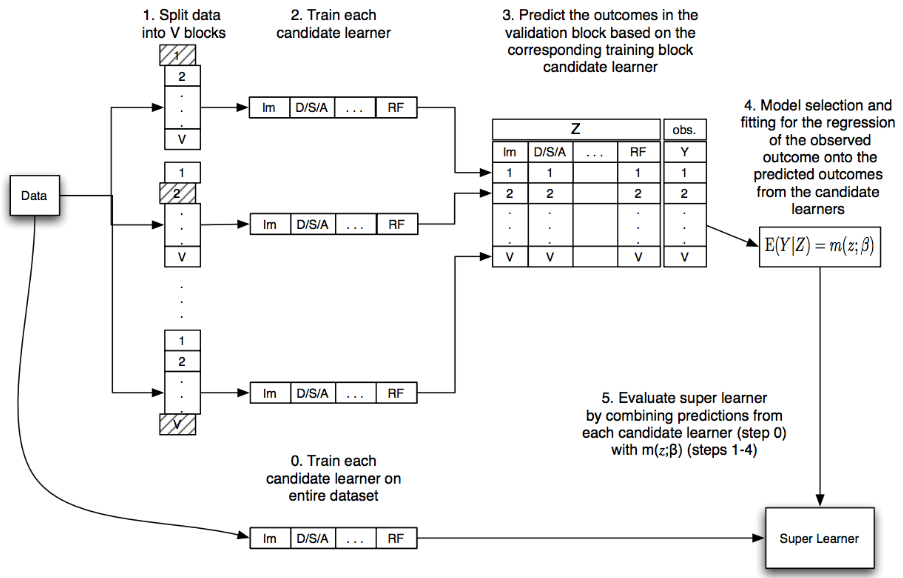

In [ ]:
import lib._util.visualplot as vp
import lib._util.fileproc as fp

In [ ]:
import pandas as pd
import numpy as np

# Scikit-Learn
from sklearn.datasets import make_blobs, make_regression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor

# ML-Ensemble
from mlens.ensemble import SuperLearner

In [ ]:
OUT_PATH_FILE  = 'resources/output/file/'
OUT_PATH_GRAPH = 'resources/output/graph/'

def get_models(method):
    methods = ['classification', 'regression']
    assert method in methods, f'method not in valid list: {methods}'
    
    if method == 'classification':
        return [
            LogisticRegression(solver='liblinear'),
            SVC(gamma='scale', probability=True),
            GaussianNB(),
            KNeighborsClassifier(),
            DecisionTreeClassifier(),
            AdaBoostClassifier(),
            BaggingClassifier(n_estimators=10),
            RandomForestClassifier(n_estimators=10),
            ExtraTreesClassifier(n_estimators=10)
        ]
    return [
        LinearRegression(),
        SVR(gamma='scale'),
        ElasticNet(),
        KNeighborsRegressor(),
        DecisionTreeRegressor(),
        AdaBoostRegressor(),
        BaggingRegressor(n_estimators=10),
        RandomForestRegressor(n_estimators=10),
        ExtraTreesRegressor(n_estimators=10)
    ]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def get_super_learner(X, method):
    methods = ['classification', 'regression']
    assert method in methods, f'method not in valid list: {methods}'

    ensemble = SuperLearner(
        scorer=accuracy_score if method == 'classification' else rmse,
        folds=10,
        shuffle=True,
        sample_size=len(X),
        verbose=2
    )
    ensemble.add(get_models(method))
    ensemble.add_meta(LogisticRegression(solver='lbfgs') if method == 'classification' else LinearRegression())
    
    return ensemble

In [ ]:
def eval_classif(y_true, y_pred):
    cofmat_df = pd.DataFrame(confusion_matrix(y_true, y_pred))
    cofmat_df.index.name   = 'True'
    cofmat_df.columns.name = 'Pred'

    print(cofmat_df)
    print()
    print(classification_report(y_true, y_pred, digits=5))
    print(f'ROC-AUC: {roc_auc_score(y_true, y_pred):.5f}')
    
def to_frame(X, y):
    data_df = pd.DataFrame(X, columns=[f'feature_{x+1}' for x in range(X.shape[1])])
    data_df['target'] = y
    
    return data_df

def get_data(method):
    methods = ['classification', 'regression']
    assert method in methods, f'method not in valid list: {methods}'
    
    if method == 'classification':
        X, y = make_blobs(n_samples=1000, centers=2, n_features=100, cluster_std=20, random_state=0)
    else:
        X, y = make_regression(n_samples=1000, n_features=100, noise=0.5, random_state=0)
    data_df = to_frame(X, y)

    X = data_df[[x for x in data_df.columns if x != 'target']].copy()
    y = data_df['target'].copy()
    
    return train_test_split(X, y, test_size=.5, stratify=y if method == 'classification' else None)

# Classification (ML-Ensemble)

In [ ]:
X_train, X_valid, y_train, y_valid = get_data('classification')

X_train.shape, X_valid.shape

In [ ]:
print('Train dataset:')
vp.value_count(y_train.to_frame(), 'target')
print('\nValidation dataset:')
vp.value_count(y_valid.to_frame(), 'target')

In [ ]:
ensemble = get_super_learner(X_train, method='classification')
ensemble.fit(X_train.values, y_train.values)
print(ensemble.data)

y_pred = ensemble.predict(X_valid)
print(f'Super Learner: {accuracy_score(y_valid, y_pred):.3f}')

In [ ]:
eval_classif(y_valid, y_pred)

# Regression (ML-Ensemble)

In [ ]:
X_train, X_valid, y_train, y_valid = get_data('regression')

X_train.shape, X_valid.shape

In [ ]:
print('Train dataset:')
print(y_train.describe())
print('\nValidation dataset:')
print(y_valid.describe())

In [ ]:
ensemble = get_super_learner(X_train, method='regression')
ensemble.fit(X_train.values, y_train.values)
print(ensemble.data)

y_pred = ensemble.predict(X_valid)
print(f'Super Learner: {rmse(y_valid, y_pred):.3f}')

# Neural Network (Stacking Models)
- Reference: https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

In [ ]:
# Scikit-Learn
from sklearn.model_selection import StratifiedKFold

# Tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC, BinaryAccuracy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.constraints import max_norm

from tqdm import tqdm

In [ ]:
X_train, X_valid, y_train, y_valid = get_data('classification')

X_train.shape, X_valid.shape

In [ ]:
print('Train dataset:')
vp.value_count(y_train.to_frame(), 'target')
print('\nValidation dataset:')
vp.value_count(y_valid.to_frame(), 'target')

In [ ]:
def get_network(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim,
                    kernel_initializer='he_uniform',
                    kernel_constraint=max_norm(5),
                    use_bias=False))
    model.add(BatchNormalization(scale=False,
                                 renorm=True,
                                 renorm_clipping={ 'rmax': 1, 'rmin': 0, 'dmax': 0 }))
    model.add(Activation('relu'))
    model.add(Dropout(rate=.2))
    
    model.add(Dense(64,
                    kernel_initializer='he_uniform',
                    kernel_constraint=max_norm(5),
                    use_bias=False))
    model.add(BatchNormalization(scale=False,
                                 renorm=True,
                                 renorm_clipping={ 'rmax': 1, 'rmin': 0, 'dmax': 0 }))
    model.add(Activation('relu'))
    model.add(Dropout(rate=.2))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Referecence: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
    metrics = [
        BinaryAccuracy(name='binary_accuracy'),
        AUC(name='auc'),
        Precision(name='precision'),
        Recall(name='recall'),
    ]
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=.001, epsilon=.00001),
                  metrics=metrics)
    
    return model

In [ ]:
def get_models(n_models, input_dim):
    return [get_network(input_dim) for _ in range(n_models)]

def get_out_of_fold_predictions(X, y, models):
    X = X.reset_index(drop=True).copy()
    y = y.reset_index(drop=True).copy()

    n_splits = 10
    splits   = StratifiedKFold(n_splits=n_splits, shuffle=True).split(X, y)
    X_metas  = []
    y_metas  = []

    for fold_index, (train_index, test_index) in enumerate(splits):
        X_train = X.loc[train_index].copy()
        X_valid = X.loc[test_index].copy()
        y_train = y.loc[train_index].copy()
        y_valid = y.loc[test_index].copy()
        y_metas.extend(y_valid)
        
        model_metas = []
        model_iter  = tqdm(enumerate(models))
        for model_index, model in model_iter:
            model_iter.set_description(f'Fold: {fold_index+1}/{n_splits} | Model: {model_index+1}/{len(models)}')
            model.fit(X_train, y_train, epochs=100, verbose=0)

            # NOTE: use predict_proba() for scikit-learn models
            model_metas.append(model.predict(X_valid))
        X_metas.append(model_metas)

    X_meta = pd.concat([
        pd.concat([pd.DataFrame(x) for x in model_metas], axis=1) for model_metas in X_metas
    ], axis=0, ignore_index=True)
    y_meta = pd.Series(y_metas, name='target')
    X_meta.columns = [x for x in range(len(X_meta.columns))]
    
    return X_meta, y_meta

def fit_base_models(X, y, models):
    for i, model in enumerate(models):
        model.fit(X, y, epochs=100, verbose=0)
        
        # Save model
        fp.create_directory(OUT_PATH_FILE)
        filename = f'model{i+1}.H5'
        model.save(f'{OUT_PATH_FILE}{filename}')
        print(f'Saved: {filename}')

def load_base_models(n_models):
    models = []
    for i in range(n_models):
        filename = f'model{i+1}.H5'
        models.append(load_model(f'{OUT_PATH_FILE}{filename}'))
        print(f'Loaded {filename}')
        
    return models

def evaluate_base_models(X, y, models):
    for model in models:
        evaluations = model.evaluate(X, y, verbose=0)
        print({x: round(evaluations[i], 3) for i,x in enumerate(model.metrics_names)})

In [ ]:
# Get base models
n_models = 5
models   = get_models(n_models=n_models, input_dim=X_train.shape[1])

# Get input & target for meta model
X_meta, y_meta = get_out_of_fold_predictions(X_train, y_train, models)
print(f'Meta Data: {X_meta.shape, y_meta.shape}')

# Fit & save base models
fit_base_models(X_train, y_train, models)

# Load & evaluate base models
models = load_base_models(n_models)
evaluate_base_models(X_valid, y_valid, models)

### Separate Stacking

In [ ]:
def fit_stacked_model(models, X, y):
    model = LogisticRegression()
    model.fit(X, y)
    
    return model

def stacked_dataset(models, X):
    X_stack = None
    for model in models:
        y_pred  = model.predict(X, verbose=0)
        X_stack = y_pred if X_stack is None else np.dstack((X_stack, y_pred))

    return X_stack.reshape((X_stack.shape[0], X_stack.shape[1] * X_stack.shape[2]))

def stacked_prediction(models, model, X):
    X_stack = stacked_dataset(models, X)
    return model.predict(X_stack)

In [ ]:
# Train meta model
model = fit_stacked_model(models, X_meta, y_meta)

y_pred = stacked_prediction(models, model, X_valid)
print(f'Super Learner: {accuracy_score(y_valid, y_pred):.3f}')

In [ ]:
eval_classif(y_valid, y_pred)

### Integrated Stacking

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [ ]:
def define_stacked_model(models):
    # Freeze layers
    for index, model in enumerate(models):
        for layer in model.layers:
            layer.trainable = False

    # Define multi-headed input
    ensemble_inputs = [model.input for model in models]

    # Concatenate output from each model
    ensemble_outputs = [model.output for model in models]
    ensemble_merged  = tf.concat(ensemble_outputs, axis=1)

    # Hidden layers
    layer = Dense(
        128,
        kernel_initializer='he_uniform',
        kernel_constraint=max_norm(5),
        use_bias=False
    )(ensemble_merged)
    layer = BatchNormalization(
        scale=False,
        renorm=True,
        renorm_clipping={ 'rmax': 1, 'rmin': 0, 'dmax': 0 }
    )(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(rate=.2)(layer)
    
    layer = Dense(
        64,
        kernel_initializer='he_uniform',
        kernel_constraint=max_norm(5),
        use_bias=False
    )(layer)
    layer = BatchNormalization(
        scale=False,
        renorm=True,
        renorm_clipping={ 'rmax': 1, 'rmin': 0, 'dmax': 0 }
    )(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(rate=.2)(layer)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(layer)
    model  = Model(inputs=ensemble_inputs, outputs=output)
    
    metrics = [
        BinaryAccuracy(name='binary_accuracy'),
        AUC(name='auc'),
        Precision(name='precision'),
        Recall(name='recall'),
    ]
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=.001, epsilon=.00001),
                  metrics=metrics)
    
    return model

def fit_stacked_model(model, X, y):
    X_input = [X for _ in range(len(model.input))]
    model.fit(X_input, y, epochs=100, verbose=2)
    
def predict_stacked_model(model, X):
    X_input = [X for _ in range(len(model.input))]
    return model.predict(X_input)

In [ ]:
# Train meta model
model = define_stacked_model(models)

fp.create_directory(OUT_PATH_GRAPH)
plot_model(model, show_shapes=True, to_file=f'{OUT_PATH_GRAPH}stacked_model.png')

In [ ]:
fit_stacked_model(model, X_train, y_train)

In [ ]:
y_pred = predict_stacked_model(model, X_valid)
y_pred = np.round(y_pred)

print(f'Super Learner: {accuracy_score(y_valid, y_pred):.3f}')

In [ ]:
eval_classif(y_valid, y_pred)